In [16]:
import networkx as nx
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.circuit import Parameter

Constructing the graph for Max Cut Problem

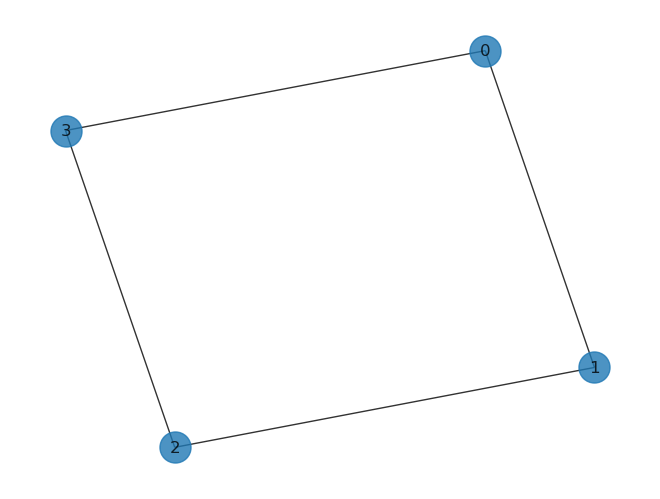

In [2]:
graph = nx.Graph()
graph.add_nodes_from([0, 1 , 2 , 3])
graph.add_edges_from([(0, 1), (1, 2), (2, 3), (3, 0)])
nx.draw(graph, alpha=0.8, with_labels=True, node_size = 500)

Constructing $H_{m}$ the simple Hamiltonian which the state  $\lvert +^{n} \rangle$ is the lowest energy state for it.

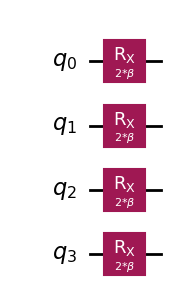

In [3]:
adj = nx.adjacency_matrix(graph).todense()

N_QUBITS = 4

mixed_h = QuantumCircuit(N_QUBITS)

beta = Parameter("$\\beta$")

for i in range(N_QUBITS):
    mixed_h.rx(2 * beta, i)
    
mixed_h.draw('mpl')

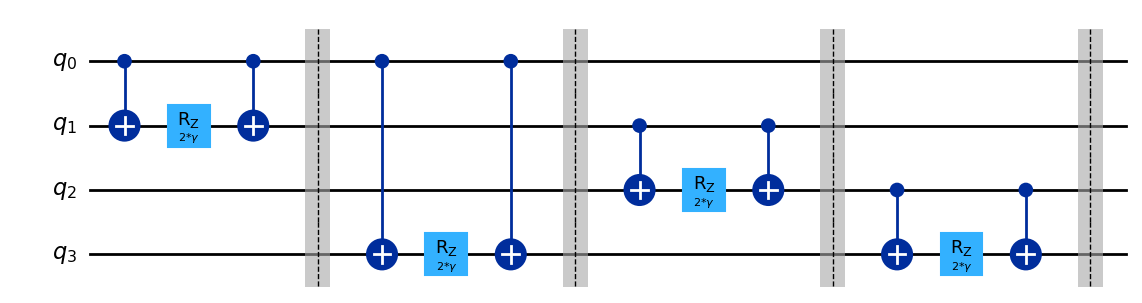

In [4]:
p_h = QuantumCircuit(N_QUBITS)

gamma = Parameter("$\\gamma$")

for edge in list(graph.edges()):
    p_h.rzz(gamma * 2, edge[0], edge[1])
    p_h.barrier()
    
p_h = p_h.decompose()
p_h.draw('mpl')

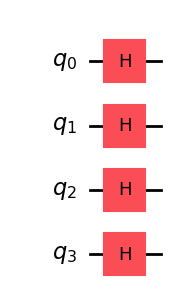

In [5]:
intial_circuit = QuantumCircuit(N_QUBITS)

for i in range(N_QUBITS):
    intial_circuit.h(i)

intial_circuit.draw('mpl')

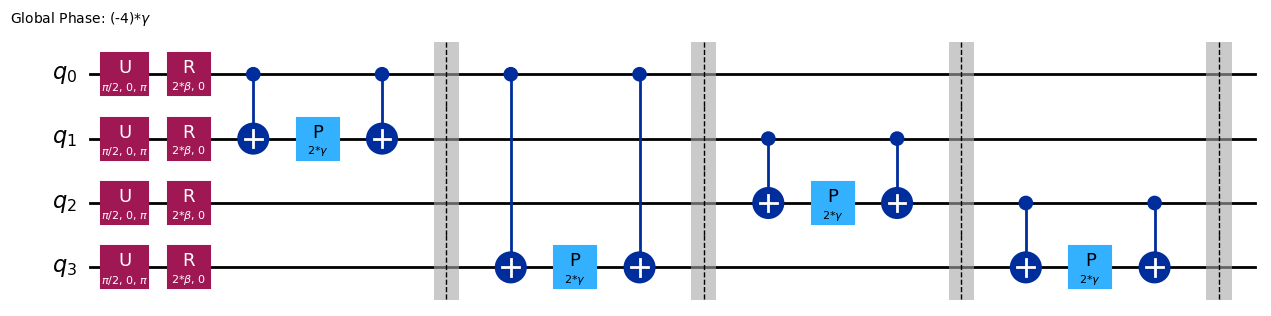

In [22]:
qc_qaoa = QuantumCircuit(N_QUBITS)
qc_qaoa.append(intial_circuit, range(N_QUBITS))
qc_qaoa.append(mixed_h, range(N_QUBITS))
qc_qaoa.append(p_h, range(N_QUBITS))

qc_qaoa.decompose().decompose().draw('mpl')

Calculating the objective function of the bit string solutions

In [7]:
def max_cut_obj(solution , graph):
    
    obj = 0 
    for i , j in graph.edges():
        if solution[i] != solution[j]:
            obj -= 1
    
    return obj

Compute the overall measurments of the circuit to get the prposed solutions and caluclate their objectives function using max_cut_obj()

In [8]:
def compute_expectation(count, graph):
    avg = 0
    sum_count = 0
    for bit_string, count in count.items():
        obj = max_cut_obj(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

Creating our QAOA circuit 

In [9]:
def create_qaoa_circuit(graph, theta):
    
    n_qubits = len(graph.nodes())
    
    n_layers = len(theta) // 2
    
    beta = theta[:n_layers]
    gamma = theta[n_layers:]
    
    qc = QuantumCircuit(n_qubits)
    
    qc.h(range(n_qubits))
    
    for layer_index in range(n_layers):
        
        for i, j in graph.edges():
            qc.rzz(2 * gamma[layer_index] , i, j)
            
        for i in range(n_qubits):
            qc.rx(2 * beta[layer_index] , i)
    
    qc.measure_all()
    
    return qc

In [17]:
def get_expectation(graph, theta):
    simulator = AerSimulator()

    def execute_circuit(theta):
        qc = create_qaoa_circuit(graph, theta)
        compiled_qc = transpile(qc, simulator)
        result = simulator.run(compiled_qc, seed_simulator=10, shots=512).result()
        counts = result.get_counts(compiled_qc)
        return compute_expectation(counts, graph)

    return execute_circuit

In [ ]:
reps = 4

In [14]:
theta = [beta, beta, beta, beta, gamma, gamma, gamma, gamma]

using COBYLA Optimizer to optimize our theta and gamma parameters

In [18]:
from scipy.optimize import minimize
expectation = get_expectation(graph, theta)
res = minimize(expectation,
               [1.0, 1.0],
               method='COBYLA')

Running our Experiment to get the best cut to gain our best solutions

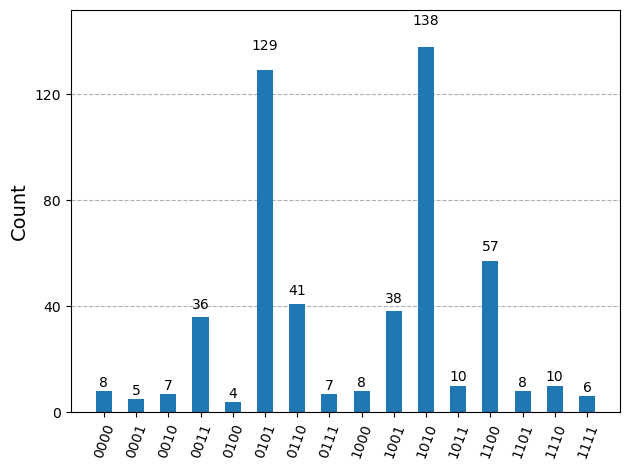

In [21]:
from qiskit.visualization import plot_histogram

simulator = AerSimulator()
qc_res = create_qaoa_circuit(graph, res.x)
compiled_qc = transpile(qc_res, simulator)
result = simulator.run(compiled_qc, seed_simulator=10, shots=512).result()
counts = result.get_counts(compiled_qc)
plot_histogram(counts)

As we notice that the bit strings "0101" and "1010" have the highest probability and are indeed the assignments of the graph (we started with) that gives 4 edges between the two partitions.